In [4]:
import os
import cv2
import random
import numpy as np



from matplotlib import pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.io import imread

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [21]:
def showPredict(images, masks, predicts):

    plt.figure(figsize=(20, 10))

    img_index = random.choice(range(len(images)))

    plt.subplot(1,4,1)
    random_img = images[img_index,:,:]
    random_img = cv2.resize(random_img, (IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(random_img, cmap='gray')
    plt.axis('off')
    plt.title('Lung X-Ray')

    plt.subplot(1,4,2)
    random_mask = masks[img_index,:,:]
    random_mask = cv2.resize(random_mask, (IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(random_mask, cmap='gray')
    plt.axis('off')
    plt.title('Mask Ground Truth')

    random_pred = predicts[img_index,:,:]
    plt.subplot(1,4,3)
    plt.imshow(random_pred, cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')
    

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    dsize2 =(400,400)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(x[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(y[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(p[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

image_path = "C:\\Users\\ugur_\\Python Projects\\DATA\\Lung Segmentation\\CXR_png\\"
mask_path = "C:\\Users\\ugur_\\Python Projects\\DATA\Lung Segmentation\\masks\\"

images = os.listdir(image_path)
mask = os.listdir(mask_path)

print(len(images), len(mask))

800 704


In [7]:
mask2 = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask2]
print(len(image_file_name), len(mask))

704 704


In [8]:
check = [i for i in mask if "mask" in i]
print(len(check))

566


In [9]:
x = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))
y = np.zeros((len(mask), IMG_HEIGHT, IMG_WIDTH))

for i, img_id in enumerate(image_file_name):
    
    file_path = image_path  + img_id + ".png"
    
    # read the file as an array
    cv2_image = cv2.imread(file_path, 0)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('img.jpg', cv2_image)
    
    # read the image using skimage
    img = imread('img.jpg')
    x[i] = img
    
    os.remove('img.jpg')

    
for i, img_id in enumerate(mask):
    
    file_path = mask_path  + img_id 
    
    # read the file as an array
    cv2_image = cv2.imread(file_path, 0)
    # resize the image
    cv2_image = cv2.resize(cv2_image, (IMG_HEIGHT, IMG_WIDTH))
    # save the image at the destination as a jpg file
    cv2.imwrite('img.jpg', cv2_image)
    
    # read the image using skimage
    img = imread('img.jpg')
    y[i] = img
    
    os.remove('img.jpg')

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_m, y_test_m = train_test_split(x, y, test_size=0.2, random_state=123)
x2 = np.flip(X_train , axis = 2)
y2 = np.flip(y_train_m , axis = 2)
X_train= np.append(X_train, x2,axis=0)
y_train_m = np.append(y_train_m, y2,axis=0)
print(X_train.shape,y_train_m.shape)
#show_random_examples(X_train, y_train_m, y_train_m)

(1126, 128, 128) (1126, 128, 128)


In [8]:
from keras_unet.models import custom_unet

model = custom_unet(
    (128, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
]

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
y_test_m2 = (y_test_m/255.> .5).astype(int)
y_train_m2 = (y_train_m/255.> .5).astype(int)

In [11]:
h = model.fit(
    X_train/255., y_train_m2,   
    callbacks=callbacks,
    validation_data=(X_test/255., y_test_m2),
    epochs=15, batch_size=20,
    #validation_split=0.2,
    #shuffle=True,
)

Epoch 1/15
57/57 [==============================] - 51s 508ms/step - loss: 0.2934 - accuracy: 0.8784 - val_loss: 10.4595 - val_accuracy: 0.2941

Epoch 00001: val_accuracy improved from -inf to 0.29414, saving model to model.h5
Epoch 2/15
57/57 [==============================] - 9s 154ms/step - loss: 0.0736 - accuracy: 0.9757 - val_loss: 0.4536 - val_accuracy: 0.9355

Epoch 00002: val_accuracy improved from 0.29414 to 0.93549, saving model to model.h5
Epoch 3/15
57/57 [==============================] - 9s 155ms/step - loss: 0.0654 - accuracy: 0.9769 - val_loss: 0.2179 - val_accuracy: 0.9281

Epoch 00003: val_accuracy did not improve from 0.93549
Epoch 4/15
57/57 [==============================] - 9s 155ms/step - loss: 0.0598 - accuracy: 0.9787 - val_loss: 0.1118 - val_accuracy: 0.9656

Epoch 00004: val_accuracy improved from 0.93549 to 0.96562, saving model to model.h5
Epoch 5/15
57/57 [==============================] - 9s 155ms/step - loss: 0.0603 - accuracy: 0.9781 - val_loss: 0.0765 

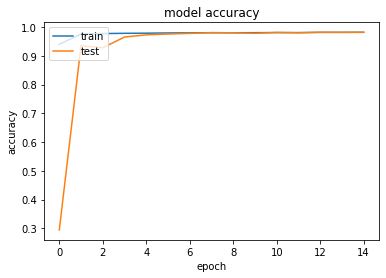

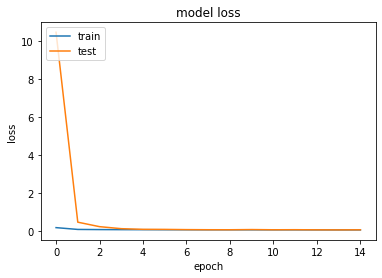

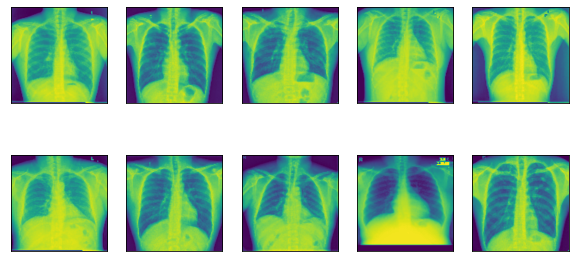

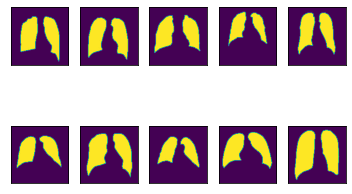

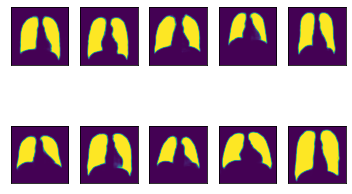

In [13]:
model = load_model("model.h5")

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

preds = model.predict(X_test/255.)*255

show_random_examples(X_test, y_test_m, preds)

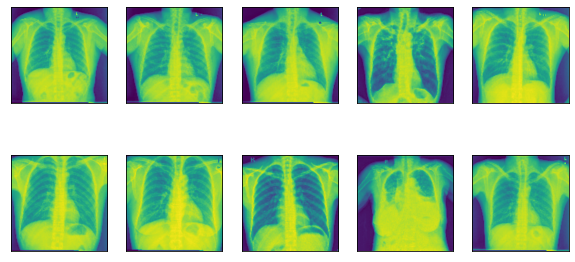

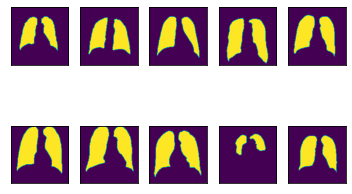

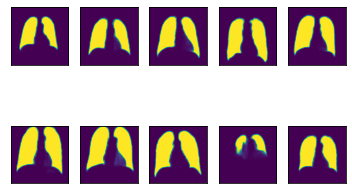

In [18]:
show_random_examples(X_test, y_test_m, preds)

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001),
    ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
]

In [23]:
h2 = model.fit(
    X_train/255., y_train_m2,
    validation_data=(X_test/255., y_test_m2),
    epochs=50, batch_size=16,
    shuffle=True,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/50
71/71 - 9s - loss: 0.0466 - accuracy: 0.9819 - val_loss: 0.0600 - val_accuracy: 0.9779

Epoch 00001: val_accuracy improved from -inf to 0.97790, saving model to model.h5
Epoch 2/50
71/71 - 8s - loss: 0.0448 - accuracy: 0.9824 - val_loss: 0.0512 - val_accuracy: 0.9824

Epoch 00002: val_accuracy improved from 0.97790 to 0.98239, saving model to model.h5
Epoch 3/50
71/71 - 9s - loss: 0.0433 - accuracy: 0.9829 - val_loss: 0.0516 - val_accuracy: 0.9823

Epoch 00003: val_accuracy did not improve from 0.98239
Epoch 4/50
71/71 - 9s - loss: 0.0433 - accuracy: 0.9827 - val_loss: 0.0566 - val_accuracy: 0.9795

Epoch 00004: val_accuracy did not improve from 0.98239
Epoch 5/50
71/71 - 9s - loss: 0.0422 - accuracy: 0.9835 - val_loss: 0.0530 - val_accuracy: 0.9819

Epoch 00005: val_accuracy did not improve from 0.98239
Epoch 6/50
71/71 - 10s - loss: 0.0420 - accuracy: 0.9832 - val_loss: 0.0514 - val_accuracy: 0.9821

Epoch 00006: val_accuracy did not improve from 0.98239
Epoch 7/50
71/71 -

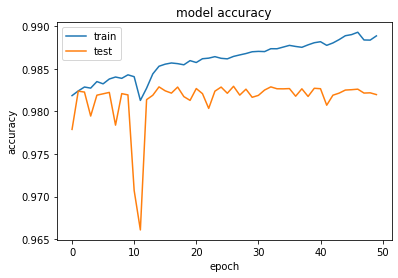

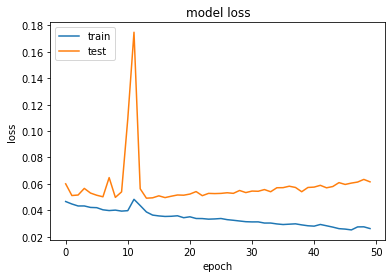

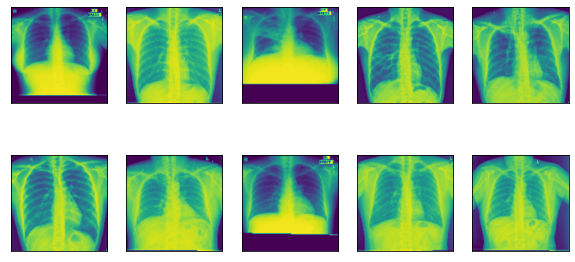

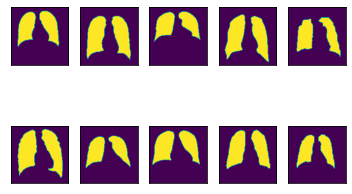

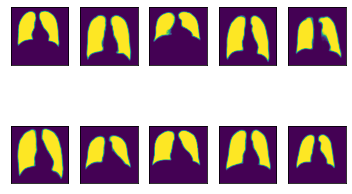

In [26]:
model = load_model('model.h5')

plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h2.history['loss']
accs = h2.history['accuracy']
val_losses = h2.history['val_loss']
val_accs = h2.history['val_accuracy']
epochs = len(losses)

preds2 = model.predict(X_test/255.)*255

show_random_examples(X_test, y_test_m, preds2)

In [33]:
model = load_model('model.h5')
predicts = model.predict(X_test/255.)*255


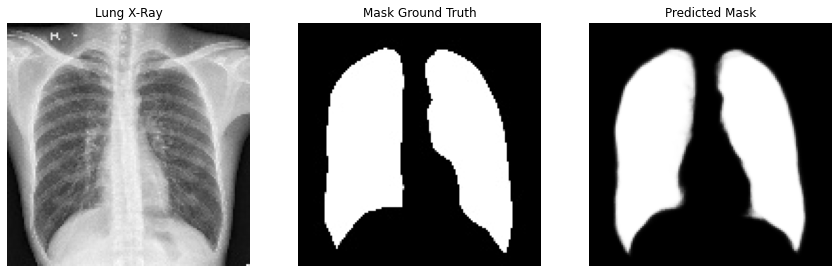

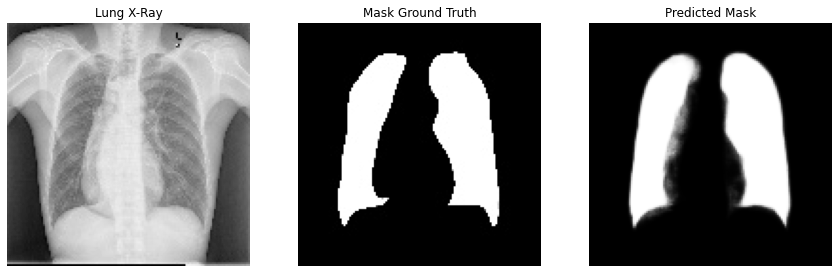

In [34]:
showPredict(X_test, y_test_m, predicts)
showPredict(X_test, y_test_m, predicts)